In [1]:
import xarray as xr 
import matplotlib.pyplot as plt 
import glob 

In [2]:
files = glob.glob('/scratch/ct715/isca_data/held_suarez_delh_omega/*/*.nc')

ds = xr.open_mfdataset(files)

In [3]:
import sys
sys.path.append('/home/links/ct715/eddy_feedback/')

import functions.eddy_feedback as ef 
import functions.aos_functions as aos

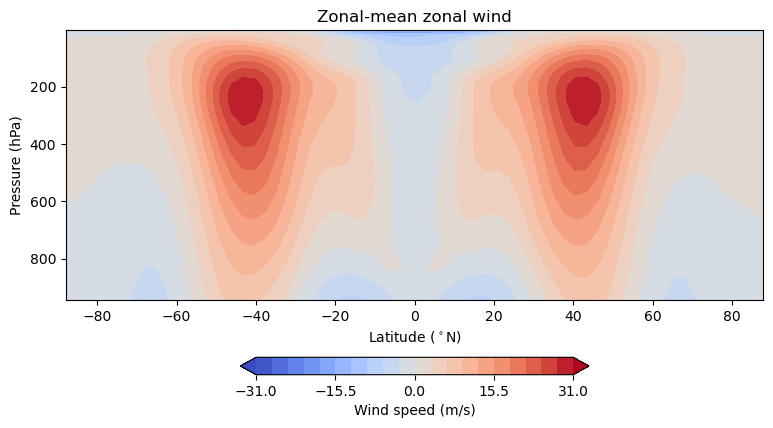

In [4]:
# This works without having to redefine ds in notebook!

ef.plot_ubar(ds)

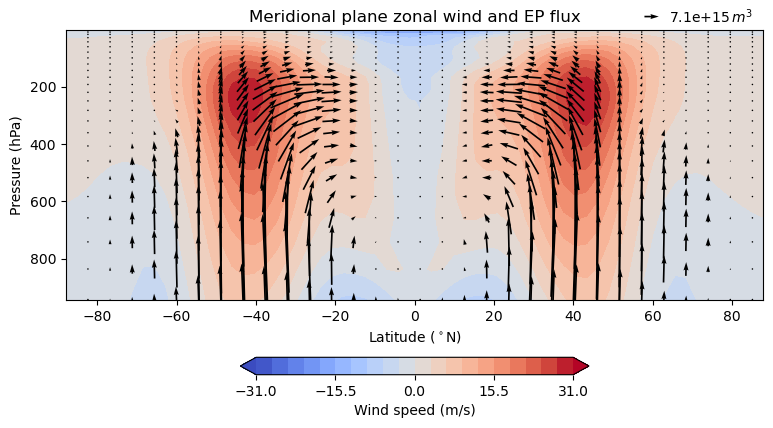

In [5]:
ef.plot_ubar_epflux(ds, skip_lat=2, skip_pres=1)

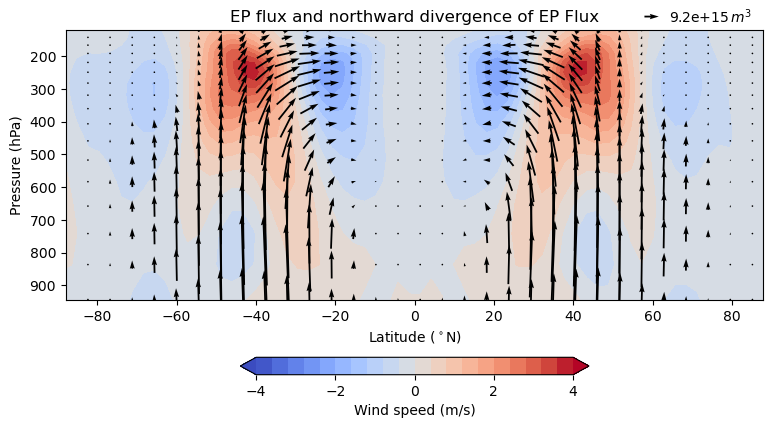

In [6]:
ef.plot_epfluxes_div(ds, skip_lat=2) 

# Correlation Plots

In [7]:
import numpy as np 
import matplotlib.pyplot as plt
import functions.aos_functions as aos


# Now redefine ds for this notebook 
ds = ef.calculate_epfluxes_ubar(ds)
ds

<xarray.Dataset>
Dimensions:      (lon: 128, lonb: 129, lat: 64, latb: 65, time: 360, nv: 2,
                  phalf: 26, level: 25)
Coordinates:
  * lon          (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lonb         (lonb) float64 -1.406 1.406 4.219 7.031 ... 353.0 355.8 358.6
  * lat          (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * latb         (latb) float64 -90.0 -86.58 -83.76 -80.96 ... 83.76 86.58 90.0
  * time         (time) object 2000-01-01 12:00:00 ... 2000-12-30 12:00:00
  * nv           (nv) float64 1.0 2.0
  * phalf        (phalf) float64 0.0 6.165 12.71 22.59 ... 786.6 886.9 1e+03
  * level        (level) float64 2.268 9.244 17.42 28.92 ... 741.7 836.3 942.9
Data variables: (12/16)
    ps           (time, lat, lon) float32 dask.array<chunksize=(30, 64, 128), meta=np.ndarray>
    bk           (time, phalf) float32 dask.array<chunksize=(30, 26), meta=np.ndarray>
    pk           (time, phalf) float32 dask.array<chunksize=(30, 26), meta=np.ndarray>
    u            (time, level, lat, lon) float32 dask.array<chunksize=(30, 25, 64, 128), meta=np.ndarray>
    v            (time, level, lat, lon) float32 dask.array<chunksize=(30, 25, 64, 128), meta=np.ndarray>
    t            (time, level, lat, lon) float32 dask.array<chunksize=(30, 25, 64, 128), meta=np.ndarray>
    ...           ...
    time_bounds  (time, nv) timedelta64[ns] dask.array<chunksize=(30, 2), meta=np.ndarray>
    ubar         (level, lat) float32 dask.array<chunksize=(25, 64), meta=np.ndarray>
    ep1          (time, level, lat) float64 -1.809e-06 -9.443e-06 ... -0.482
    ep2          (time, level, lat) float64 6.842e-11 1.562e-10 ... -0.004506
    div1         (time, level, lat) float64 -2.665e-06 -5.916e-06 ... 0.8996
    div2         (time, level, lat) float64 -5.055e-07 -1.155e-06 ... 6.721 2.26
Attributes:
    filename:   /scratch/ct715/isca_work/experiment/held_suarez_delh_omega/ru...
    title:      FMS Model results
    grid_type:  regular
    grid_tile:  N/A

In [8]:
#======================================================================================================================================

#-------------------- 
# CORRELATION PLOTS
#--------------------


def correlation_contourf(ds, top_atmos=100.,
                         show_div2=False, logscale=True, show_rect=True, primitive=True):
    
    """"
    Input: dataset that contains ep fluxes data
            - with variables: (time, level, lat, lon)
    
    Output: contourf plot matching Fig.6 in Smith et al., 2022
    """
    
    ## CONDITIONS
    
    # ensure variables are named correctly
    if 'lat' and 'lon' and 'level' and 'u' and 'v' and 't' not in ds:
        ds = ef.find_rename_variables(ds)  
    
    # Check to see if EP fluxes are in DataSet
    if not 'ep1' in ds:
        ds = ef.calculate_epfluxes_ubar(ds, primitive=primitive)
        
    # set northern hemisphere
    ds = ds.where( ds.lat >= 0 )
    
    # cut off stratosphere
    ds = ds.where( ds.level >= top_atmos )
    
    #------------------------------------------------------------------
    
    ## SET UP TIME
    
    # remove unwanted variables
    vars = ['u', 'div1', 'div2']
    ds = ds[vars]
        
    # set variables and save them
    ubar = ds.u.mean(('lon'))
    div1 = ds.div1
    div2 = ds.div2
    
    # separate time into annual means
    ubar = ubar.load()
    div1 = div1.mean('time').load()
    div2 = div2.mean('time').load()
    
    # choose which variable; default: div1
    if show_div2==True:
        corr = correlation_array(ubar, div2)
        title_name = '\\nabla_p F_p'
        figgy = (6,7)
    else:
        corr = correlation_array(ubar, div1)
        title_name = '\\nabla_{\\phi} F_{\\phi}'
        figgy = (6,6)
        
    import matplotlib.patches as patches

    plt.figure(figsize=figgy)

    plt.contourf(ds.lat.values, ds.level.values, corr, cmap='RdBu_r', levels=15,
             extend='both')
    plt.colorbar(location='bottom', orientation='horizontal', shrink=0.75, label='correlation',
             extend='both', ticks=[-0.6,-0.2,0.2,0.6])
    plt.gca().invert_yaxis()
    
    if logscale==True:
        plt.yscale('log')
        

    plt.xlabel('Latitude $(^\\circ N)$')
    plt.ylabel('Log pressure (hPa)')
    plt.title('(a) $Corr(\\bar{{u}}, {0})$'.format(title_name))

    if show_rect == True:
        rect = patches.Rectangle((25., 600.), 50, -400, 
                         fill=False, linewidth=2)
        plt.gca().add_patch(rect)

    plt.show()
    

#--------------------------------------------------------------------------------------------------------------------------------
    
    
# correlation on a grid function
def correlation_array(da1, da2):
    
    """
    Input: two Xarray DataArrays of same shape (time,level,lat)
    
    Output: a NumPy array of correlation coefficients,
            of shape (level, lat)
            
            
    !!! Might need to check .load() otherwise will run
        for VERY long time
    
    """
    
    
    # create array of desired shape
    da_corr = np.zeros((len(da1[0,:,0]), len(da1[0,0,:])))
    
    # loop through each variable
    # on each row, do each column entry
    for i in range(len(da1[0,:,0])):
        for j in range(len(da1[0,0,:])):
        
            # calculate correlation coefficient
            corr = np.corrcoef(da1[:,i, j], da2[:,i, j])  
            # save coefficient to respective data point
            da_corr[i, j] = corr[0,1]
        
            
    return da_corr 


In [9]:
correlation_contourf(ds)

IndexError: too many indices